#Алгоритм "Глубокая Детерминированная Градиентная Политика"
###(Англ: Deep Deterministic Policy Gradient)

"Глубокая Детерминированная Градиентная Политика" (ГДГП) - это алгоритм, который предназначен для работы с непрерывными пространствами действий. По сути, этот алгоритм является модификацией алгоритма Q-обучения, предназначеного для непрерывных пространств действий. Также, присутствуют некоторые элементы алгоритма "преймущественный актёр-критик".

##**Ключевые моменты**

* Алгоритм ГДГП является внеполитическим (off-policy) - в нём присутствует буфер памяти, и сеть обучается во время взаимодействие со средой в рамках эпизода.

* ГДГП применим только к ситуациям где есть непрерывное пространство действий, по сколько он подразумивает градиент между пространством действий и получаемыми вознаграждениями. 

* В алгоритме ГДГП как правило присутствуют четыре нейронные сети: основной актёр, целевой актёр, основной критик, и целевой критик.

___________________________________________________________

##Основные модели - актёр и критик

Чтобы понять суть алгоритма ГДГП, нам сначала нужно задать вопрос: "почему алгоритм Q-обучения не подходит для непрерывных пространств действий?"

**Q-обучение не подходит для непрерывных пространств действий потому что алгоритм принимает действие по максимальному Q-значению max(Q(s, a)) - а найти максимальное значение из непрерывного пространства действий (т.е. бесконечное количество возможных действий) не возможно.**

ГДГП решает эту проблему следующим путем: вместо того, чтобы пытаться обучить сеть на бесконечным количестве возможных различных действий, создается отдельная сеть, чья задача - предсказать целесообразность любого действия при заданным состоянии среды. Эта часть алгоритма называется **критик**.

Критик принимает в себя состояние и предпологаемое действие (s, a), и предсказывает итоговое Q-значение. Как и в алгоритме Q-обучения, наш критик обучается используя любую функцию ошибки, пригодной для регрессии (в литературе обычно используется MSE). 

По сколько итоговая функция Q(s, a) получается непрерывной (т.е. у неё есть градиент), мы можем использовать итоговые предсказания от критика для обучения основной части алгоритма - **актёра**. Т.е. актёр в буквальном смысле будет обучаться так, чтобы принимать действия которые максимизируют предсказания критика.

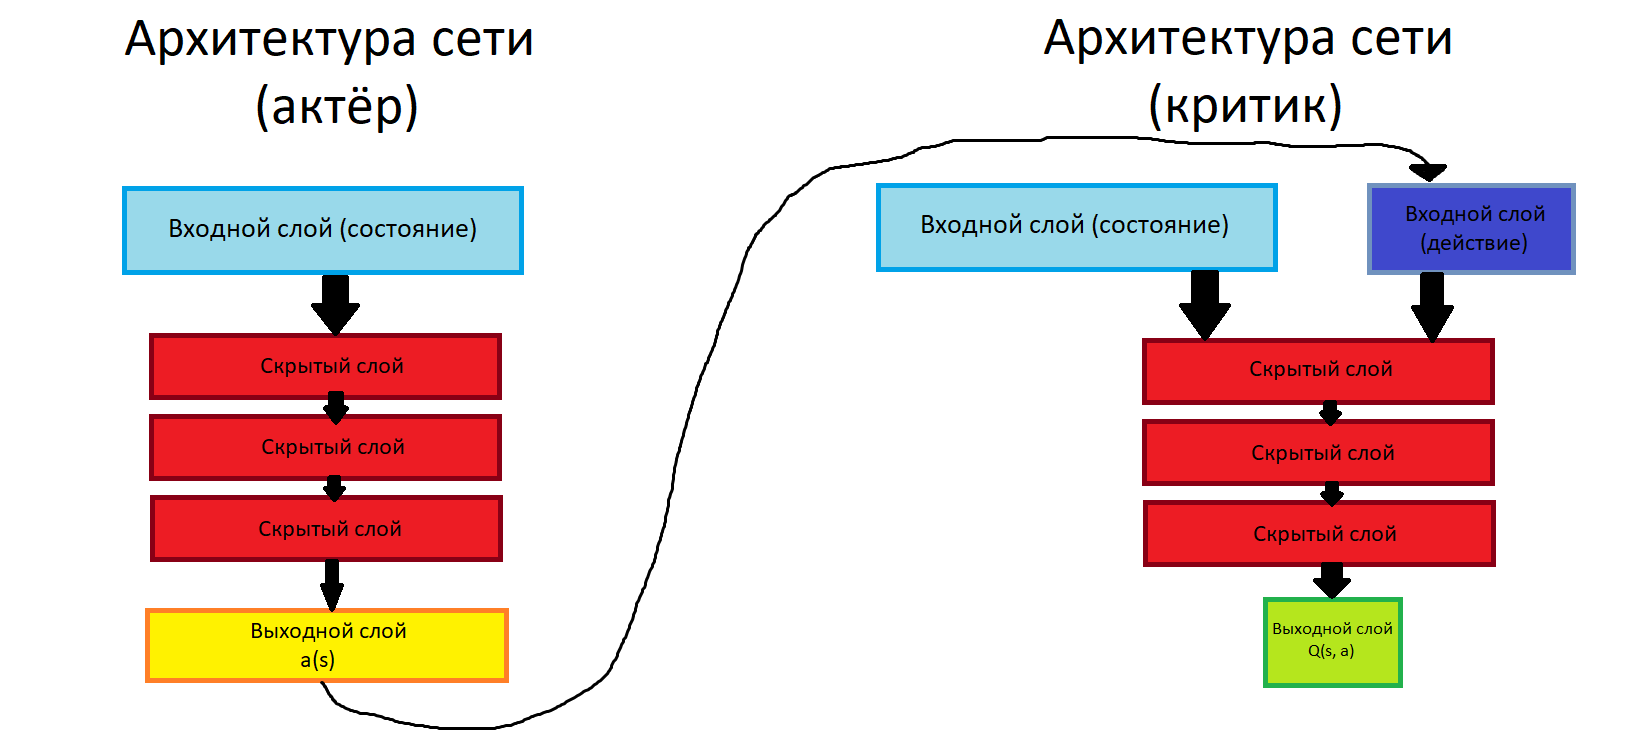

**ИЗОБРАЖЕНИЕ №1**

<font color='gray'>Визуализация архитектуры нейронной сети актёра и нейронной сети критика в алгоритме ГДГП. Актёр принимает на вход состояние среды (s), и выдает действие (a). Критик принимает на вход действие (a(s)) выданно актёром, а также состояние среды (s) для предсказания Q-значения (Q(s, a)) через уровнение Бэллмена.</font>

In [ ]:
##ПСЕВДОКОД ДЛЯ НАГЛЯДНОСТИ

actor_model = create_actor_model()                                                  #Создаем предпологаемую модель актёра
critic_model = create_critic_model()                                                #Создаем предпологаемую модель критика

critic_value = critic_model([batch_current_states, predicted_actions])                  #Считаем значения Q(s, a) от критика по действиям a, которые предсказал актёр
actor_loss = -tf.math.reduce_mean(critic_value)                                         #Актёр пытается максимизировать значение критика

actor_gradients = tape.gradient(actor_loss, actor_model.trainable_variables)            #Считаем градиенты по ошибки актёра
actor_optimizer.apply_gradients(zip(actor_gradients, actor_model.trainable_variables))  #Применяем градиенты к модели - т.е. обучаем сеть

<font color='gray'>Из-за того что нам приходиться использовать предсказание одной модели в качестве значения ошибки второй модели, мы не можем написать данный алгоритм полностью на керасе. Приходиться "капнуть глубже" в фреймворк и использовать функционал тензорфлоу.</font>
________________________________________________________________________________

##Целевые модели - актёр и критик

В алгоритме ГДГП, целевые сети используются по такой же причине, как и в алгоритме Q-обучения - без них, ошибки нейронок в работе с рекурсивным уровнением складываются и становяться кумулятивными (тем временем как с разными сетями, они более склонны отменять друг-друга). То есть, присутствие целевых моделей помогает стабилизировать обучение всего алгоритма.

Однако, в отличии от Q-обучения, ГДГП не просто копирует веса из основной модели в целевую модель раз в каждые N итераций. Вместо этого, используется **мягкое обновление модели** по следующему уравнению:

$W_{target} = 𝜏*W_{main} + (1 - 𝜏)*W_{target}$

Давайте посмотрим на выше-указанное уравнение в коде:


In [ ]:
def update_target_weights(main_model_weights, target_model_weights):             #Функция принимает на вход веса основной модели и целевой модели
  for (W_main, W_target) in zip(main_model_weights, target_model_weights):       #В цикле проходимся по весам и смещениям каждого слоя
    W_target.assign(tau * W_main + (1 - tau) * W_target)                         #Производим "мягкое" обновления с гиперпараметром tau

Выше-указанная функция вызовается на каждом этапе обучения, что позволяет весам целевых моделей "плавно" сливаться с весами основных моделей. Но, из-за того что основные модели обучаются, веса целевых моделей всегда будут немного "отставать" от основных моделей по времени.

Гиперпараметр 𝜏 определяет скорость с которой веса из конкретно выбранной целевой модели стремятся к весам её соответствующей основной модели. Чем выше значение 𝜏, тем быстрее веса целевой моделью стремяться к весам основной модели.

Данный вид обновления весов целевой модели называется *мягкое обновление* (тем временем, как обновление весов из алгоритма Q-обучения называется *жёсткое обновление*). Из-за того, что мягкое обновление весов плавно и медленно меняет модель на каждом шаге, оно считается более стабильным и воспомогающим для обучение чем жёсткое обновление.

##Исследование среды - шум

Последнее что нужно отметить, это что алгоритм ГДГП использует радномность - т.е. *шум* для исследование среды агентом. Этот механизм работает точно также, как в алгоритме PPO с непрерывными действиями - шум просто суммируется с выходом сети актёра чтобы добавить некий элемент рандомности.

В статье о алгоритме ГДГП (2015 г.) используется особый вид шума - шум Орнштейна-Уленбека (по сути, основан на моделировании Броуновского движения). Но нам в это углубляться не нужно, по сколько последующие эксперименты и научные исследования показали что алгоритм вполне достаточно хорошо справляется и с простым Гауссовским шумом *(функция `np.random.normal()`)*. В этом занятии будет использован именно вариант алгоритма с гауссовским шумом.

Величина шума определяется двумя параметрами: гиперпараметр σ (**standard_deviation**), и параметр ε (**epsilon**). В данном случае ε имеет такое же поведение, как и в Q-обучении - этот параметр инициализируется под высоким значением (как правило ε=1), и плавно снижается во время обучения, пока оно не достигнет своего минимального значения.

Шум для данного алгоритма можно посчитать следующим образом:

In [ ]:
noise = epsilon * np.random.normal(0, standard_deviation, size = action_space) #Указываем шум, который определяется гиперпараметром standard_deviation и параметром epsilon.
action = model.predict(state) + noise  #Добавляем шум к предсказанию сетиы
action = np.clip(action, -1, 1)        #Урезаем результат, чтобы все числа были в нужном диапазоне (в данном случае [-1, +1])

#ПРИМЕЧАНИЕ: action_space - это размер пространства действий (размерность выходного слоя модели актёра)

##Внешние ресурсы:

[arXiv статья по алгоритму ГДГП (DDPG)](https://arxiv.org/abs/1509.02971)

[Deep Deterministic Policy Gradient(DDPG) — an off-policy Reinforcement Learning algorithm](https://medium.com/intro-to-artificial-intelligence/deep-deterministic-policy-gradient-ddpg-an-off-policy-reinforcement-learning-algorithm-38ca8698131b)

[Реализация ГДГП (DDPG) на сайте keras.io с преминением шума Орнштейна-Уленбека](https://keras.io/examples/rl/ddpg_pendulum/)